## Sentiment Analysis for Social Media Data
### By: Aashi

In [63]:
from pprint import pprint
import pandas as pd
import numpy as np

!pip install -q praw

import praw
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sa
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

!pip3 install gensim
import gensim.downloader as api
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [64]:
#defining the praw reddit tool
user_agent = "Data 1.0"
reddit = praw.Reddit(
    client_id="eMB6WKPL5okjyK0HEp-jLA",
    client_secret="nI8rPm-U8OVJGbhxx5EplOsZlAEsiA",
    user_agent=user_agent
)

Accessing data from  subreddits named : "Worldnews", "sadp', "Dreams" and "happy".

In [65]:

titles = set() #to restrict repetition of titles

def extract_remaining_rate_limit(response_headers):  #for esuring there is no problem with extracting titles
    try:
        #extract remaining rate limit value from response headers
        remaining_rate_limit = float(response_headers.get("x-ratelimit-remaining", "0").split(',')[0])
        return remaining_rate_limit
    except ValueError:
        return 0  # Return 0 if there's an issue with the rate limit header

#extracting titles from the subreddits
for submission in reddit.subreddit('worldnews').new(limit= None):
    titles.add(submission.title)
    remaining_limit = extract_remaining_rate_limit(reddit.auth.limits)

for submission in reddit.subreddit('sad').new(limit=None):
    titles.add(submission.title)
    remaining_limit = extract_remaining_rate_limit(reddit.auth.limits)

for submission in reddit.subreddit('Dreams').new(limit= None):
    titles.add(submission.title)
    remaining_limit = extract_remaining_rate_limit(reddit.auth.limits)

for submission in reddit.subreddit('happy').new(limit= None):
    titles.add(submission.title)
    remaining_limit = extract_remaining_rate_limit(reddit.auth.limits)

print(f"Amount of lines generated: {len(titles)}")

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Amount of lines generated: 2809


Converting this data extracted to a dataframe

In [66]:
data = pd.DataFrame(titles)
data.head()
data.to_csv("data.csv", header=False, encoding='utf-8', index= False ) #converting it to a csv

Using vader_lexicon for sentiment analysing

In [67]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [68]:
sia = sa() #creating an analyser
sentimented_sentences = []

#doing a sentiment classification on the data extracted
for i in titles:
    score = sia.polarity_scores(i) #making a dictionary
    score['Post'] = i
    sentimented_sentences.append(score)

pprint(sentimented_sentences[:3], width = 150)

[{'Post': '19/03/25 - Posting daily updates on what made me happy', 'compound': 0.5719, 'neg': 0.0, 'neu': 0.684, 'pos': 0.316},
 {'Post': 'Netanyahu makes vow to Trump over tariffs on Israel', 'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'Post': "EU pauses countermeasures following Trump's tariff reprieve", 'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}]


In [69]:
df_sentimented = pd.DataFrame.from_records(sentimented_sentences) #making a new dataframe of the sentiment analysed dictionary

display(df_sentimented.head())

,neg,neu,pos,compound,Post
0,0.000,0.684,0.316,0.5719,19/03/25 - Posting daily updates on what made ...
1,0.000,1.000,0.000,0.0000,Netanyahu makes vow to Trump over tariffs on I...
2,0.000,1.000,0.000,0.0000,EU pauses countermeasures following Trump's ta...
3,0.000,1.000,0.000,0.0000,N Korea holds first international marathon in ...
4,0.237,0.763,0.000,-0.4767,Zelenskyy urges 'tough' Russia measures after ...


Giving the data in the dataframe a sentiment value: 1 for positive, -1 for negative and 0 for neutral

In [70]:
df_sentimented["Sen Label"] = 0
df_sentimented.loc[df_sentimented['compound'] > 0.2, "Sen Label"] = 1
df_sentimented.loc[df_sentimented['compound'] <  -0.2, "Sen Label"] = -1
df_sentimented.head()

,neg,neu,pos,compound,Post,Sen Label
0,0.000,0.684,0.316,0.5719,19/03/25 - Posting daily updates on what made ...,1
1,0.000,1.000,0.000,0.0000,Netanyahu makes vow to Trump over tariffs on I...,0
2,0.000,1.000,0.000,0.0000,EU pauses countermeasures following Trump's ta...,0
3,0.000,1.000,0.000,0.0000,N Korea holds first international marathon in ...,0
4,0.237,0.763,0.000,-0.4767,Zelenskyy urges 'tough' Russia measures after ...,-1


In [71]:
df_sentimented_updated = df_sentimented[["Post", "Sen Label"]]
df_sentimented_updated.to_csv("data_sen.csv", encoding='utf-8', index=False)
df_sentimented_updated.head()

,Post,Sen Label
0,19/03/25 - Posting daily updates on what made ...,1
1,Netanyahu makes vow to Trump over tariffs on I...,0
2,EU pauses countermeasures following Trump's ta...,0
3,N Korea holds first international marathon in ...,0
4,Zelenskyy urges 'tough' Russia measures after ...,-1


### PREPROCESSING

In [72]:
# Initialize stopwords and lemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [73]:


def r_urls(text): #removing urls function
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def r_html(text): #remving html function
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# Emoji expression code
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           "]+", flags=re.UNICODE)


def r_hashtags(text): #removing hashtags function
    return re.sub(r'#\w+', '', text)

def r_emojis(text): #removing emojis function
    return emoji_pattern.sub(r'', text)

#This function is for removing: URLs,HTML tags,hashtags,emojis from the text
def preprocess_text(text):
    text = text.lower()
    #text = r_slang(text, slang_dict)
    text = r_urls(text)  # Remove
    text = r_html(text)  # Remove
    text = r_hashtags(text)  # Remove
    text = r_emojis(text)  # Remove
    tokens = word_tokenize(text)     # Tokenization

    # Remove stopwords and non-alphanumeric characters
    clean_tokens = []
    for word in tokens:
        if word.isalnum() and word not in stop_words:
            clean_tokens.append(word)

    # Lemmatization
    lemmatized_tokens = []
    for word in clean_tokens:
        lemmatized_word = lemmatizer.lemmatize(word)
        lemmatized_tokens.append(lemmatized_word)

    return ' '.join(lemmatized_tokens)

In [74]:

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [75]:
#preprocessing the actual data
df_sentimented_process = df_sentimented[["Post", "Sen Label"]].copy()

df_sentimented_updated['Processed_Post'] = df_sentimented_process['Post'].apply(preprocess_text)

display(df_sentimented_updated.head())

# Optionally, save to CSV
df_sentimented_updated.to_csv("processed_data.csv", index=False)

<ipython-input-75-44d3706c4eec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentimented_updated['Processed_Post'] = df_sentimented_process['Post'].apply(preprocess_text)


,Post,Sen Label,Processed_Post
0,19/03/25 - Posting daily updates on what made ...,1,posting daily update made happy
1,Netanyahu makes vow to Trump over tariffs on I...,0,netanyahu make vow trump tariff israel
2,EU pauses countermeasures following Trump's ta...,0,eu pause countermeasure following trump tariff...
3,N Korea holds first international marathon in ...,0,n korea hold first international marathon six ...
4,Zelenskyy urges 'tough' Russia measures after ...,-1,zelenskyy urge russia measure trump show frust...


### FEATURE EXTRACTION

In [76]:
processed_posts = df_sentimented_updated['Processed_Post']

# Create a Bag-of-Words vectorizer
vectorizer = CountVectorizer()

# Fit and transform your preprocessed posts
bow_features = vectorizer.fit_transform(processed_posts)
word_freq = np.sum(bow_features.toarray(), axis=0)
#making a dataframe for unique words and their frequency and give the top 10
word_freq_df = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'freq': word_freq}).nlargest(10, 'freq')

word_freq_df.head(10)


,word,freq
1440,dream,595
2116,happy,256
2748,made,178
4478,tariff,164
5017,year,158
3932,say,143
4680,trump,136
4575,time,112
1790,first,107
1214,day,106


In [77]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform your preprocessed posts
tfidf_features = tfidf_vectorizer.fit_transform(processed_posts)
# tfidf_features is now a sparse matrix containing TF-IDF features for your dataset

tfidf_means = np.mean(tfidf_features.toarray(), axis=0)
#making a dataframe for unique words and their frequency and give the top 10
tfidf_df = pd.DataFrame({'word': tfidf_vectorizer.get_feature_names_out(), 'tfidf': tfidf_means}).nlargest(10, 'tfidf')
tfidf_df.head(10)

,word,tfidf
1440,dream,0.048601
2116,happy,0.024309
2748,made,0.020434
4767,update,0.016702
3415,posting,0.016534
1190,daily,0.016509
4478,tariff,0.012456
5017,year,0.012033
4680,trump,0.010935
3932,say,0.010418


In [78]:
# Load pre-trained Word2Vec embeddings
word2vec_model = api.load("glove-twitter-25")

# Function to vectorize a sentence into an embedding
def document_vector(doc):
    words_in_doc = doc.split()
    valid_words = []
    for word in words_in_doc:
        if word in word2vec_model.key_to_index:  # Checking if the word is in the model's vocabulary
            valid_words.append(word)  # If the word is valid append it

    # Check if there are valid words in the document and return their vector mean
    if valid_words:
        return np.mean(word2vec_model[valid_words], axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

# Applying the function over here
word2vec_features = df_sentimented_updated['Processed_Post'].apply(document_vector)
word2vec_f = np.array([document_vector(post) for post in processed_posts])
cosine_sim_word2vec = cosine_similarity(word2vec_f)
print("Cosine Similarity (Word2Vec):")
pprint(cosine_sim_word2vec)

word2vec_features.to_csv("processed_featuredata.csv", index=False)

Cosine Similarity (Word2Vec):
array([[1.        , 0.68051447, 0.66450741, ..., 0.8469704 , 0.91380364,
        0.86471241],
       [0.68051447, 1.        , 0.78856139, ..., 0.672907  , 0.7014199 ,
        0.64794647],
       [0.66450741, 0.78856139, 1.        , ..., 0.65422075, 0.70954673,
        0.60591962],
       ...,
       [0.8469704 , 0.672907  , 0.65422075, ..., 1.        , 0.92682628,
        0.92738129],
       [0.91380364, 0.7014199 , 0.70954673, ..., 0.92682628, 1.        ,
        0.8949125 ],
       [0.86471241, 0.64794647, 0.60591962, ..., 0.92738129, 0.8949125 ,
        1.        ]])


### MODEL SELECTION AND TRAINING

In [79]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, df_sentimented_updated['Sen Label'], test_size=0.2, random_state=50)


In [80]:
# Initialize the SVM model
svm_model = SVC()

# Train the model with the training data
svm_model.fit(X_train, y_train)


SVC()

In [81]:
#Make predictions on the training set and test set
y_train_pred = svm_model.predict(X_train)
y_test_pred = svm_model.predict(X_test)

#Evaluate the performance
print("Training Performance:")
print(classification_report(y_train, y_train_pred))

print("Testing Performance:")
print(classification_report(y_test, y_test_pred))


Training Performance:
              precision    recall  f1-score   support

          -1       1.00      0.97      0.99       472
           0       0.98      0.98      0.98       792
           1       0.98      0.99      0.99       983

    accuracy                           0.99      2247
   macro avg       0.99      0.98      0.99      2247
weighted avg       0.99      0.99      0.99      2247

Testing Performance:
              precision    recall  f1-score   support

          -1       0.85      0.22      0.35       105
           0       0.55      0.81      0.66       186
           1       0.81      0.78      0.79       271

    accuracy                           0.69       562
   macro avg       0.74      0.60      0.60       562
weighted avg       0.73      0.69      0.66       562



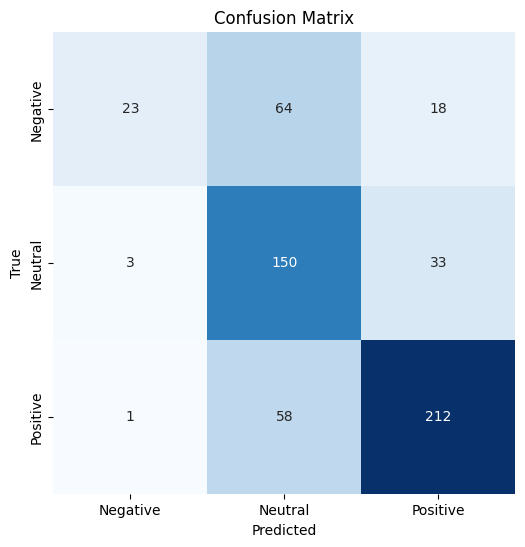

In [82]:
classes = ['Negative', 'Neutral', 'Positive']
confusion = confusion_matrix(y_test, y_test_pred)
# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [83]:
import joblib
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']